## Building data input pipelines 
>* using the tf.keras.preprocessing.image.ImageDataGenerator class 
## Overfitting issues

In [3]:
import tensorflow as tf
# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [5]:
# data loading
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=_URL, extract=True)

# list directories
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/home/ubuntu/.keras/datasets
/home/ubuntu/.keras/datasets/fashion-mnist
/home/ubuntu/.keras/datasets/cats_and_dogs_filtered
/home/ubuntu/.keras/datasets/cats_and_dogs_filtered/validation
/home/ubuntu/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/home/ubuntu/.keras/datasets/cats_and_dogs_filtered/validation/cats
/home/ubuntu/.keras/datasets/cats_and_dogs_filtered/train
/home/ubuntu/.keras/datasets/cats_and_dogs_filtered/train/dogs
/home/ubuntu/.keras/datasets/cats_and_dogs_filtered/train/cats


In [8]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [9]:
# understanding the data
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [10]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [11]:
# model parameters
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE = 150

In [12]:
# data ppreparation to format the data into proper floating point tensors
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [15]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE, IMG_SHAPE), #(150,150)
                                                           class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE, IMG_SHAPE),
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [16]:
sample_training_images, _ = next(train_data_gen)

The next function returns a batch from the dataset. One batch is a tuple of (many images, many labels). 

For right now, we're discarding the labels because we just want to look at the images.

In [19]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1,5,figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

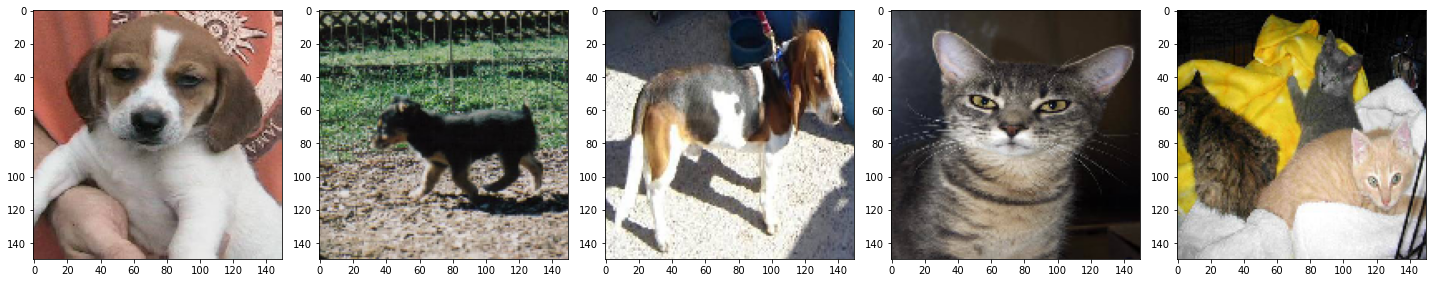

In [20]:
plotImages(sample_training_images[:5])

In [24]:
strategy = tf.distribute.MirroredStrategy()
#print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

with strategy.scope():
    # Model creation
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', 
                               input_shape=(150,150,3)),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(2)
    ])   

    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    model.summary()
    
    EPOCHS = 100
    history = model.fit_generator(
        train_data_gen,
        steps_per_epoch=int(np.ceil(total_train/float(BATCH_SIZE))),
        epochs=EPOCHS,
        validation_data=val_data_gen,
        validation_steps=int(np.ceil(total_val/float(BATCH_SIZE)))
    )

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 17, 17, 128)     

/tmp/ipykernel_3587/3169573656.py:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
2022-07-31 13:47:39.934137: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1012"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020FlatMapDataset:1"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
 

Epoch 1/100


2022-07-31 13:47:45.351694: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-07-31 13:47:46.674846: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


20/20 [==============================] - ETA: 0s - loss: 0.7212 - accuracy: 0.5225

2022-07-31 13:47:54.431042: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_3282"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021FlatMapDataset:27"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key

20/20 [==============================] - 19s 502ms/step - loss: 0.7212 - accuracy: 0.5225 - val_loss: 0.6755 - val_accuracy: 0.5260
Epoch 2/100
20/20 [==============================] - 10s 488ms/step - loss: 0.6927 - accuracy: 0.5210 - val_loss: 0.6901 - val_accuracy: 0.5040
Epoch 3/100
20/20 [==============================] - 10s 487ms/step - loss: 0.6821 - accuracy: 0.5485 - val_loss: 0.6731 - val_accuracy: 0.5390
Epoch 4/100
20/20 [==============================] - 10s 520ms/step - loss: 0.6666 - accuracy: 0.5775 - val_loss: 0.6800 - val_accuracy: 0.5420
Epoch 5/100
20/20 [==============================] - 10s 506ms/step - loss: 0.6455 - accuracy: 0.6155 - val_loss: 0.6487 - val_accuracy: 0.6110
Epoch 6/100
20/20 [==============================] - 9s 476ms/step - loss: 0.5875 - accuracy: 0.6875 - val_loss: 0.6054 - val_accuracy: 0.6750
Epoch 7/100
20/20 [==============================] - 9s 469ms/step - loss: 0.5302 - accuracy: 0.7335 - val_loss: 0.5562 - val_accuracy: 0.7190
Epoch 

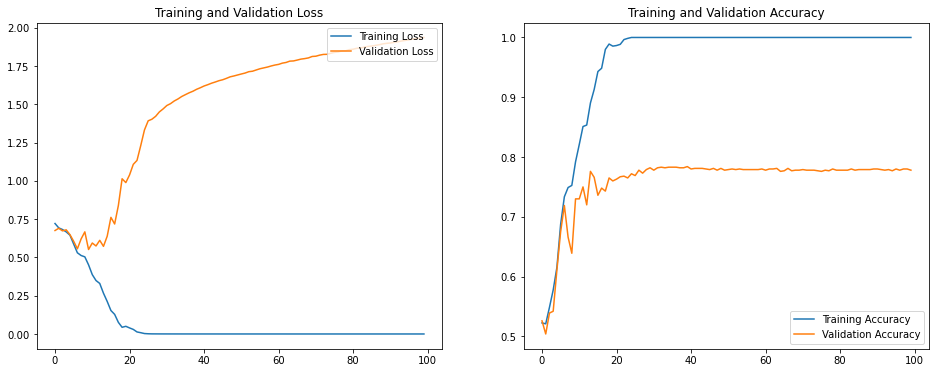

In [29]:
def plot_train(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(EPOCHS)

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.savefig('./foo.png')
    plt.show()
    
plot_train(history)